<a href="https://colab.research.google.com/github/mirianbatista/covid-fatores/blob/master/regressao_linear_mortalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
import io
import gzip
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import seaborn as sns

In [ ]:
idhm = pd.read_excel('https://github.com/mirianbatista/covid-fatores/blob/master/atlas2013_dadosbrutos_pt.xlsx?raw=true', sheet_name=1, dtype = {'UF': str, 'Codmun7':str}) 

In [ ]:
url = "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
cols = 'state','city','city_ibge_code','date','estimated_population_2019','last_available_deaths'
response = requests.get(url)
bytes_io = io.BytesIO(response.content)
with gzip.open(bytes_io, 'rt') as read_file:
    covid = pd.read_csv(read_file, usecols=cols, parse_dates=["date"], dtype={"city_ibge_code": str})
covid = covid[covid.date == max(covid.date)]
covid['last_available_death_rate'] = 100000 * covid['last_available_deaths'] / covid['estimated_population_2019']

In [ ]:
covid

,city,city_ibge_code,date,estimated_population_2019,last_available_deaths,state,last_available_death_rate
9917,Acrelândia,1200013,2021-06-30,15256.0,36,AC,235.972732
9918,Assis Brasil,1200054,2021-06-30,7417.0,24,AC,323.580963
9919,Brasiléia,1200104,2021-06-30,26278.0,38,AC,144.607657
9920,Bujari,1200138,2021-06-30,10266.0,17,AC,165.595169
9921,Capixaba,1200179,2021-06-30,11733.0,17,AC,144.890480
...,...,...,...,...,...,...,...
2337323,Tupirama,1721257,2021-06-30,1891.0,2,TO,105.764146
2337324,Tupiratins,1721307,2021-06-30,2671.0,3,TO,112.317484
2337325,Wanderlândia,1722081,2021-06-30,11683.0,15,TO,128.391680
2337326,Xambioá,1722107,2021-06-30,11540.0,29,TO,251.299827


In [ ]:
idhmcovid = pd.merge(idhm, covid, left_on="Codmun7", right_on="city_ibge_code", how="left") 
idhmcovid = idhmcovid.loc[(idhmcovid['estimated_population_2019'] > 20000) & (idhmcovid['ANO'] == 2010)].dropna()
idhmcovid.head()

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_deaths,state,last_available_death_rate
11130,2010,11,110001,1100015,ALTA FLORESTA D'OESTE,70.75,2.24,23.8,25.49,47.37,94.50,83.18,5.84,8.67,1.22,1.52,11.99,1.68,13.00,2.72,15.76,57.62,63.21,66.39,20.36,18.97,25.81,22.03,17.82,7.79,90.45,107.69,45.99,35.40,21.23,85.25,92.88,34.60,34.15,10.50,...,1577,4788,1536,16399,1497,3211,1433,13188,399,429,413,2196,5170,1425,1145,747,8605,6284,10422,24392,13970,20434.0,2401.0,1602.0,16431.0,24097,22429,0.368,0.629,0.641,0.526,0.763,0.657,Alta Floresta D'Oeste,1100015,2021-06-30,22945.0,65,RO,283.286119
11131,2010,11,110002,1100023,ARIQUEMES,73.36,1.91,19.2,20.53,46.68,96.12,87.69,4.36,9.18,1.55,1.09,7.90,1.13,8.53,1.89,10.48,58.43,60.96,72.93,22.22,22.30,23.11,19.35,16.74,3.96,94.78,106.62,58.77,46.92,27.95,85.46,91.31,37.07,40.96,12.91,...,5497,18019,5420,60024,5330,12522,5360,47502,1522,1565,1564,8593,19709,3943,4515,2739,32552,23467,13828,90353,76525,74725.0,9256.0,5256.0,60213.0,89766,88730,0.514,0.648,0.702,0.600,0.806,0.716,Ariquemes,1100023,2021-06-30,107863.0,461,RO,427.394009
11133,2010,11,110004,1100049,CACOAL,74.27,1.90,14.3,15.38,43.79,96.41,88.56,5.57,9.74,1.01,0.80,8.29,0.93,8.94,1.57,10.95,66.69,71.14,71.07,17.74,16.28,21.60,15.57,12.58,7.33,100.81,108.09,80.94,54.45,38.23,88.24,93.02,43.97,51.33,17.45,...,4729,15592,4770,54164,4617,10863,4634,43301,1180,1218,1216,6454,15675,4378,3708,2333,29758,21922,16653,78574,61921,66376.0,7473.0,4547.0,54356.0,78141,76876,0.488,0.698,0.718,0.620,0.821,0.727,Cacoal,1100049,2021-06-30,85359.0,277,RO,324.511768
11138,2010,11,110009,1100098,ESPIGÃO D'OESTE,74.15,2.22,15.4,16.47,46.83,96.41,88.54,5.21,9.55,2.17,1.28,11.33,1.11,12.18,2.54,14.87,65.19,70.26,66.35,18.72,17.42,28.68,16.09,12.32,4.97,97.47,106.42,71.24,32.47,18.67,86.99,92.12,38.96,30.29,9.83,...,1639,5407,1617,19295,1647,3768,1645,15527,501,519,459,2492,5866,1496,1399,830,10260,7564,8119,28729,20610,23897.0,2849.0,1653.0,19395.0,28510,27791,0.402,0.619,0.672,0.536,0.819,0.691,Espigão D'Oeste,1100098,2021-06-30,32374.0,60,RO,185.333910
11139,2010,11,110010,1100106,GUAJARÁ-MIRIM,74.39,2.61,14.8,15.92,56.67,96.53,88.88,4.82,8.17,2.20,1.77,8.06,1.99,8.70,2.78,10.47,48.13,51.27,66.81,25.26,26.82,24.91,26.61,21.91,8.27,96.87,107.88,61.70,43.87,17.32,85.03,91.06,31.72,40.96,5.66,...,2595,7875,2513,25380,2382,5280,2264,20100,814,847,834,4403,9694,2006,2161,1334,13993,10094,6449,41656,35207,33017.0,4602.0,2575.0,25841.0,39928,38203,0.486,0.537,0.657,0.519,0.823,0.663,Guajará-Mirim,1100106,2021-06-30,46174.0,223,RO,482.955776


In [ ]:
idhmcovid_cor_abs = idhmcovid.drop(columns=['ANO', 'Codmun6', 'Codmun7', 'Município', 'last_available_deaths', 'estimated_population_2019']).corr(method='spearman').abs()
correlacao_abs = idhmcovid_cor_abs.loc['last_available_death_rate'].sort_values(ascending=False).to_frame().reset_index().rename(columns = {'index': 'indicador'})[1:101]
correlacao_abs

,indicador,last_available_death_rate
1,REN2,0.638096
2,CORTE9,0.635953
3,CORTE4,0.634906
4,RDPC4,0.632135
5,REN3,0.631938
...,...,...
96,TRABSC,0.446548
97,HOMEM45A49,0.444470
98,MULH50A54,0.444069
99,T_FREQSUPER1517,0.443209


In [ ]:
idhmcovid_cor_abs_colin = idhmcovid_cor_abs[correlacao_abs['indicador']].unstack().sort_values(ascending=False).reset_index(name='correlation')
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.correlation >= 0.8]
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_0", right_on="indicador", how="right").rename(columns = {'last_available_death_rate': 'cor_1'}).drop(columns='indicador')
idhmcovid_cor_abs_colin = pd.merge(idhmcovid_cor_abs_colin, correlacao_abs, left_on="level_1", right_on="indicador", how="right").rename(columns = {'last_available_death_rate': 'cor_2'}).drop(columns='indicador')
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.cor_1 > idhmcovid_cor_abs_colin.cor_2]
idhmcovid_cor_abs_colin = idhmcovid_cor_abs_colin[idhmcovid_cor_abs_colin.level_0 != idhmcovid_cor_abs_colin.level_1]

In [ ]:
import numpy as np
idhmcovid_cor_abs_colin_cols = idhmcovid_cor_abs_colin.level_1.unique()
idhmcovid_cor_abs_colin_cols = np.append(idhmcovid_cor_abs_colin_cols, 'T_SLUZ')
idhmcovid_cor_abs_colin_cols

array(['CORTE9', 'CORTE4', 'RDPC4', 'REN3', 'RENOCUP', 'IDHM_R', 'RDPC',
       'RDPCT', 'IDHM', 'CORTE3', 'RDPC3', 'T_FUNDIN_TODOS_MMEIO',
       'CORTE2', 'PPOB', 'RDPC5', 'RDPC2', 'PPOBCRI', 'REN5', 'PMPOB',
       'CORTE1', 'PMPOBCRI', 'T_FBSUPER', 'P_FUND', 'T_FLSUPER', 'RDPC1',
       'RDPC10', 'T_FUNDIN18MINF', 'REN1', 'IDHM_E', 'T_FUND25M',
       'I_ESCOLARIDADE', 'T_FUND18M', 'T_SUPER25M', 'T_CRIFUNDIN_TODOS',
       'PIND', 'RPOB', 'T_MED18A24', 'P_SUPER', 'T_FUND18A24', 'PINDCRI',
       'T_MED18M', 'REN0', 'T_AGUA', 'P_MED', 'T_ANALF25A29', 'MORT1',
       'T_ANALF25M', 'T_ANALF18A24', 'T_MED25M', 'T_MED18A20', 'MORT5',
       'T_BANAGUA', 'T_ANALF18M', 'T_FUNDIN_TODOS', 'T_MED19A21',
       'T_ANALF15M', 'P_AGRO', 'P_FORMAL', 'T_ANALF11A14', 'RAZDEP',
       'T_NESTUDA_NTRAB_MMEIO', 'AGUA_ESGOTO', 'IDHM_L', 'ESPVIDA',
       'T_ANALF15A17', 'T_RMAXIDOSO', 'T_ATRASO_2_BASICO', 'T_FUND16A18',
       'TRABCC', 'I_FREQ_PROP', 'T_FUND15A17', 'T_ATRASO_2_FUND', 'RMPOB',
       

In [ ]:
pd.DataFrame(idhmcovid_cor_abs_colin.level_1.unique(), columns=['col1']).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   col1    92 non-null     object
dtypes: object(1)
memory usage: 864.0+ bytes


In [ ]:
corr_pos_neg = idhmcovid[correlacao_abs['indicador']].drop(columns=idhmcovid_cor_abs_colin_cols)
corr_posit_negat = corr_pos_neg.columns
corr_pos_neg

,REN2,T_MULCHEFEFIF014,T_LIXO,EMP,pesourb,T_FREQMED1824,T_OCUPDESLOC_1,T_FREQSUPER1517
11130,78.80,14.51,94.05,2.83,13970,4.73,1.15,2.73
11131,70.18,18.07,96.72,2.30,76525,4.99,0.16,0.18
11133,70.72,12.80,98.17,2.09,61921,6.91,0.43,0.44
11138,73.07,24.70,91.07,1.09,20610,9.35,0.53,0.49
11139,74.98,22.46,90.41,0.46,35207,10.55,0.27,0.35
...,...,...,...,...,...,...,...,...
16673,73.08,8.87,98.83,2.15,12669,5.28,1.17,0.00
16680,76.14,16.69,98.84,0.94,100106,5.08,2.23,1.20
16685,69.93,11.39,99.34,0.91,33796,7.61,0.62,2.69
16688,64.46,19.26,97.60,0.86,132982,7.80,2.36,1.12


In [ ]:
mortalidade = idhmcovid.last_available_death_rate
xtrain_corr_pos_neg, xtest_corr_pos_neg, ytrain_corr_pos_neg, ytest_corr_pos_neg = train_test_split(corr_pos_neg, mortalidade, test_size=0.4, random_state=42)

In [ ]:
linreg_corr_pos_neg = LinearRegression()
linreg_corr_pos_neg.fit(corr_pos_neg, mortalidade)
print('linear model coeff (w): {}'
.format(linreg_corr_pos_neg.coef_))
print('linear model intercept (b): {:.3f}'
.format(linreg_corr_pos_neg.intercept_))
print('R-squared score (all data): {:.3f}'
.format(linreg_corr_pos_neg.score(corr_pos_neg, mortalidade)))
print('R-squared score (train): {:.3f}'
.format(linreg_corr_pos_neg.score(xtrain_corr_pos_neg, ytrain_corr_pos_neg)))
print('R-squared score (test): {:.3f}'
.format(linreg_corr_pos_neg.score(xtest_corr_pos_neg, ytest_corr_pos_neg)))

linear model coeff (w): [-3.14995942e+00 -1.16308571e+00  7.90862659e-01 -1.63223198e+00
  9.07585810e-06 -1.23713784e+00 -2.36882723e+00  8.81163491e+00]
linear model intercept (b): 407.077
R-squared score (all data): 0.408
R-squared score (train): 0.410
R-squared score (test): 0.404


In [ ]:
pd.DataFrame({'variavel': corr_posit_negat, 'coeficiente': linreg_corr_pos_neg.coef_}).sort_values('coeficiente', ascending=False)

,variavel,coeficiente
7,T_FREQSUPER1517,8.811635
2,T_LIXO,0.790863
4,pesourb,0.000009
1,T_MULCHEFEFIF014,-1.163086
5,T_FREQMED1824,-1.237138
3,EMP,-1.632232
6,T_OCUPDESLOC_1,-2.368827
0,REN2,-3.149959


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

X = corr_pos_neg
y = mortalidade
model = LinearRegression()

preprocessor = make_column_transformer(
    (StandardScaler(), corr_posit_negat),
    remainder='passthrough'
)

model = make_pipeline(
    preprocessor,
    LinearRegression()
)

_ = model.fit(X, y)

X_preprocessed = pd.DataFrame(
    model.named_steps['columntransformer'].transform(X),
    columns=corr_posit_negat
)

cv_model = cross_validate(
    model, X, y, cv=RepeatedKFold(n_splits=5, n_repeats=5),
    return_estimator=True, n_jobs=-1
)

coefs = pd.DataFrame(
    [est.named_steps['linearregression'].coef_ * X_preprocessed.std(axis=0) for est in cv_model['estimator']], columns=corr_posit_negat
)


coefs1 = pd.DataFrame(
    [model['linearregression'].coef_ * X_preprocessed.std(axis=0)], columns=corr_posit_negat
)
coefs1

,REN2,T_MULCHEFEFIF014,T_LIXO,EMP,pesourb,T_FREQMED1824,T_OCUPDESLOC_1,T_FREQSUPER1517
0,-37.512858,-10.794957,7.952032,-1.855026,3.190047,-4.251723,-3.802893,9.20811


In [ ]:
d

,T_FREQSUPER1517,T_LIXO,pesourb,EMP,T_OCUPDESLOC_1,T_FREQMED1824,Mães chefe de família,Ocupados com 2 salários
0,9.20811,7.952032,3.190047,-1.855026,-3.802893,-4.251723,-10.794957,-37.512858


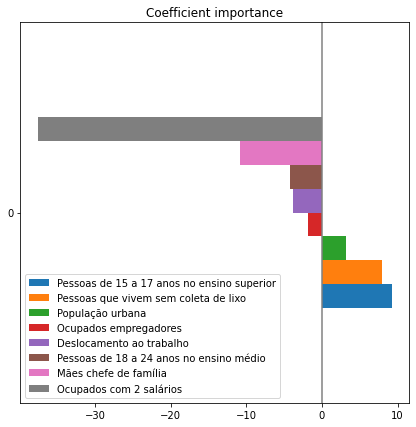

In [ ]:
a = pd.melt(coefs1, var_name="var", value_name="Value").sort_values(by="Value", ascending=False)
b = a['var'].to_list()
c = coefs1[b]
d = c.rename(columns = {"T_FREQSUPER1517": "Pessoas de 15 a 17 anos no ensino superior", "T_LIXO": "Pessoas que vivem sem coleta de lixo", "pesourb": "População urbana", "EMP": "Ocupados empregadores", "T_OCUPDESLOC_1": "Deslocamento ao trabalho", "T_FREQMED1824": "Pessoas de 18 a 24 anos no ensino médio", "T_MULCHEFEFIF014": "Mães chefe de família", "REN2": "Ocupados com 2 salários"})
d.plot(kind='barh', figsize=(9, 7))
plt.title('Coefficient importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

**REN2**: Percentual dos ocupados com rendimento de até 2 salários mínimos\
**T_MULCHEFEFIF014**: Percentual de mães chefes de família, sem fundamental completo e com pelo menos um filho menor de 15 anos de idade\
**T_LIXO**: Percentual da população que vive em domicílios urbanos com serviço de coleta de lixo\
**EMP**: Percentual de ocupados de 18 anos ou mais que são empregadores\
**pesourb**: População urbana\
**T_FREQMED1824**: Percentual da população de 18 a 24 anos de idade frequentando o ensino médio\
**T_OCUPDESLOC_1**:    Percentual de pessoas em domicílios vulneráveis à pobreza e que gastam mais de uma hora até o trabalho\
**T_FREQSUPER1517**: Percentual da população de 15 a 17 anos de idade frequentando o ensino superior\
\
descrição de todas as variáveis do IDHM: https://docs.google.com/spreadsheets/d/1CBN0-0Og-hRN-ovSAEbobgzhUxTZt3CoVsq1YMXpss4/edit?usp=sharing

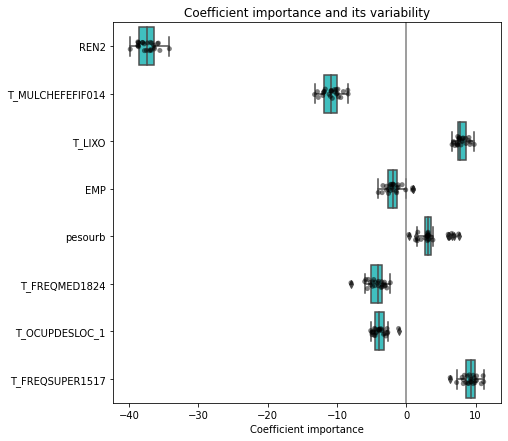

In [ ]:
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient='h', color='k', alpha=0.5)
sns.boxplot(data=coefs, orient='h', color='cyan', saturation=0.5)
plt.axvline(x=0, color='.5')
plt.xlabel('Coefficient importance')
plt.title('Coefficient importance and its variability')
plt.subplots_adjust(left=.3)

In [ ]:
pred_corr_pos_neg = linreg_corr_pos_neg.predict(xtest_corr_pos_neg)
print('Mean squared error: %.2f'
      % mean_squared_error(ytest_corr_pos_neg, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(ytest_corr_pos_neg, pred_corr_pos_neg))

Mean squared error: 5152.40
Coefficient of determination: 0.40


In [ ]:
pred_corr_pos_neg = model.predict(X)
print('Mean squared error: %.2f'
      % mean_squared_error(y, pred_corr_pos_neg))
print('Coefficient of determination: %.2f'
      % r2_score(y, pred_corr_pos_neg))

Mean squared error: 5169.84
Coefficient of determination: 0.41


In [ ]:
fig = go.Figure(data=go.Scatter(x=y, y=pred_corr_pos_neg, mode='markers', text=idhmcovid['Município'] + "-" + idhmcovid['state'])) 
fig.update_layout(title="Valores reais e previstos das maiores correlações de mortalidade de COVID-19 com indicadores do IDHM")
fig.show()

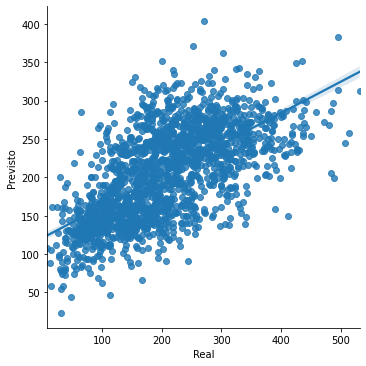

In [ ]:
df_corr_pos_neg = pd.DataFrame ({'Real': y, 'Previsto': pred_corr_pos_neg}) 
sns.lmplot(x="Real", y="Previsto", data=df_corr_pos_neg)

In [ ]:
idhmcovid.sort_values('REN2')

,ANO,UF,Codmun6,Codmun7,Município,ESPVIDA,FECTOT,MORT1,MORT5,RAZDEP,SOBRE40,SOBRE60,T_ENV,E_ANOSESTUDO,T_ANALF11A14,T_ANALF15A17,T_ANALF15M,T_ANALF18A24,T_ANALF18M,T_ANALF25A29,T_ANALF25M,T_ATRASO_0_BASICO,T_ATRASO_0_FUND,T_ATRASO_0_MED,T_ATRASO_1_BASICO,T_ATRASO_1_FUND,T_ATRASO_1_MED,T_ATRASO_2_BASICO,T_ATRASO_2_FUND,T_ATRASO_2_MED,T_FBBAS,T_FBFUND,T_FBMED,T_FBPRE,T_FBSUPER,T_FLBAS,T_FLFUND,T_FLMED,T_FLPRE,T_FLSUPER,...,peso1517,PESO1524,PESO1618,PESO18,Peso1820,PESO1824,Peso1921,PESO25,peso4,peso5,peso6,PESO610,Peso617,PESO65,PESOM1014,PESOM1517,PESOM15M,PESOM25M,pesoRUR,pesotot,pesourb,PIA,PIA1014,PIA1517,PIA18M,POP,POPT,I_ESCOLARIDADE,I_FREQ_PROP,IDHM,IDHM_E,IDHM_L,IDHM_R,city,city_ibge_code,date,estimated_population_2019,last_available_deaths,state,last_available_death_rate
14941,2010,35,354880,3548807,SÃO CAETANO DO SUL,78.20,1.30,9.50,11.02,41.07,95.79,87.84,13.89,11.04,1.06,0.56,1.55,0.41,1.59,0.39,1.76,75.88,80.47,74.44,14.26,12.16,17.45,9.86,7.37,8.11,99.56,104.52,86.45,101.19,76.78,90.91,91.73,64.88,72.32,35.89,...,5514,20489,5649,121019,5946,14975,6236,106044,1461,1429,1435,7588,18060,20728,4238,2707,69331,59138,0,149263,149263,134996.0,8612.0,5451.0,120933.0,148195,148195,0.762,0.836,0.862,0.811,0.887,0.891,São Caetano do Sul,3548807,2021-06-30,161127.0,797,SP,494.640873
14351,2010,33,330330,3303302,NITERÓI,76.23,1.41,12.91,14.52,40.54,93.43,84.14,12.17,9.68,1.50,0.84,2.27,0.74,2.34,0.92,2.59,62.30,65.45,73.93,21.00,20.93,20.12,16.70,13.62,5.95,101.59,110.89,76.27,86.51,74.14,88.95,92.32,50.00,63.26,36.40,...,19175,71540,19500,386285,21044,52365,21862,333920,4862,5038,5068,27484,65153,59321,15513,9466,221283,185246,0,487562,487562,437702.0,31430.0,19447.0,386825.0,482950,482761,0.794,0.762,0.837,0.773,0.854,0.887,Niterói,3303302,2021-06-30,513584.0,1868,RJ,363.718496
15466,2010,42,420200,4202008,BALNEÁRIO CAMBORIÚ,78.62,1.31,8.70,10.25,34.68,95.92,88.17,7.75,10.47,0.73,0.56,1.50,0.36,1.55,0.53,1.80,76.07,77.62,83.45,14.99,14.46,15.21,8.94,7.92,1.33,93.15,101.69,71.61,73.61,55.61,85.96,91.83,50.00,62.94,30.29,...,4851,19472,5097,83787,5801,14621,6142,69166,1164,1208,1184,6284,15526,8380,3647,2434,47227,37291,0,108089,108089,96124.0,7496.0,4826.0,83802.0,107149,107149,0.763,0.803,0.845,0.789,0.894,0.854,Balneário Camboriú,4202008,2021-06-30,142295.0,360,SC,252.995537
14938,2010,35,354850,3548500,SANTOS,76.13,1.25,13.70,15.36,44.51,95.14,85.23,14.05,10.84,1.04,0.72,2.22,0.65,2.29,0.83,2.53,76.88,79.21,81.58,14.54,14.00,14.89,8.57,6.80,3.54,102.40,106.32,91.44,95.58,52.52,91.03,93.30,62.78,71.02,26.50,...,16191,58202,16338,332936,17202,42011,17807,290925,4378,4471,4442,23417,55279,58911,12921,8016,193233,163958,314,419400,419086,375661.0,26442.0,15940.0,333279.0,416553,416524,0.758,0.832,0.840,0.807,0.852,0.861,Santos,3548500,2021-06-30,433311.0,1883,SP,434.560858
15527,2010,42,420540,4205407,FLORIANÓPOLIS,77.35,1.23,10.81,12.14,34.08,95.43,86.89,7.50,10.79,1.03,0.88,2.07,0.53,2.14,0.52,2.47,73.76,77.70,76.12,14.57,13.40,17.85,11.67,8.90,6.03,96.47,103.50,78.28,62.82,73.12,88.74,92.34,52.95,51.90,35.23,...,18216,73562,18932,326360,22020,55346,23214,271014,4664,4576,4560,25052,59721,31592,14053,9150,180339,143741,15954,421240,405286,373988.0,28471.0,18445.0,327072.0,417579,417546,0.800,0.800,0.847,0.800,0.873,0.870,Florianópolis,4205407,2021-06-30,500973.0,1008,SC,201.208448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11744,2010,21,211010,2110104,SANTA QUITÉRIA DO MARANHÃO,70.61,3.38,27.40,29.90,72.58,93.59,82.80,6.05,8.34,14.88,9.57,32.83,12.60,35.61,23.40,42.70,44.92,49.90,51.08,21.70,22.93,39.40,33.38,27.17,9.51,106.35,119.69,61.44,78.84,9.33,88.74,92.44,25.07,61.83,2.94,...,1995,5925,1961,16684,1747,3930,1637,12754,694,699,711,3739,7865

In [ ]:
fig = go.Figure(data=go.Scatter(x=y, y=idhmcovid['REN2'], mode='markers', text=idhmcovid['Município'] + "-" + idhmcovid['state'])) 
fig.update_layout(title="Percentual dos ocupados com rendimento de até 2 salários mínimos e a mortalidade de covid-19 por município")
fig.show()

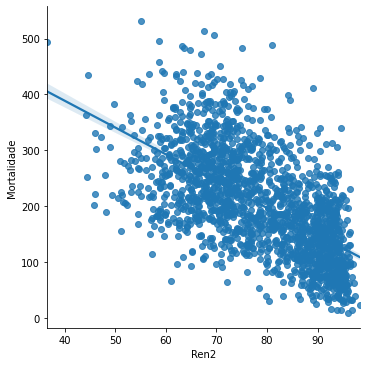

In [ ]:
mort_ren2 = pd.DataFrame ({'Ren2': idhmcovid['REN2'], 'Mortalidade': mortalidade}) 
sns.lmplot(x="Ren2", y="Mortalidade", data=mort_ren2)